In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
model=models.resnet50(pretrained=True)
# model=models.vgg16(pretrained=True)
model.eval()

C:\Users\benny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\benny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
# Dictionaries to store the feature maps (forward pass output) and gradients (backward pass output)
feature_maps = {}
gradients = {}

def save_feature_maps(module, input, output):
    """
    Hook to store the feature maps (A_k) outputted by the targeted layer 
    during the forward pass.

    Args:
        module: The module that registered the hook (the targeted layer).
        input: The input tensor(s) to the module.
        output (torch.Tensor): The output feature map tensor (the A tensor).
    """
    # Detaching the tensor is sometimes necessary to save memory, 
    # but not strictly required here as we only read the output.
    feature_maps['feature_maps'] = output 

def save_gradients(module, grad_input, grad_output):
    """
    Hook to store the gradients (∂Yc/∂A_k) calculated by the targeted layer 
    during the backward pass (after target_logit.backward()).

    Args:
        module: The module that registered the hook.
        grad_input: The gradient tensor(s) flowing into the module.
        grad_output (tuple): The gradient tensor(s) flowing out of the module.
    """
    # We store the gradient tensor from the first element of the grad_output tuple
    # which corresponds to the gradient w.r.t the module's output.
    gradients['grads'] = grad_output[0]

In [5]:
# Target Layer Selection 
# For ResNet, the target is usually the last convolutional layer in 'layer4'.
target_layer = model.layer4[-1].conv3 # Last convolutional layer

# For Vgg16 (alternative)
# target_layer = model.features[28] # Last convolutional layer of VGG16

# Registering the hooks on the target layer
# The forward hook will capture the feature maps (A_k)
target_layer.register_forward_hook(save_feature_maps)
# The backward hook will capture the gradients (∂Yc/∂A_k)
target_layer.register_backward_hook(save_gradients)

In [6]:
# Image Loading and Forward Pass
img = Image.open("data/chat_roux.jpg")

# Preprocessing pipeline for the model input
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Apply standard ImageNet normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Preprocess, add the batch dimension (1, C, H, W), and move to device
img_tensor = preprocess(img).unsqueeze(0).to(DEVICE)
# Keep a NumPy version of the original image (resized) for later visualization
original_img_np = np.array(img.resize((224, 224)))

# Enable gradient tracking on the input tensor. 
img_tensor.requires_grad_(True) 


output = model(img_tensor)
probabilities = torch.softmax(output, dim=1)
predicted_class = torch.argmax(probabilities).item()
print(f"Predicted Class (ID): {predicted_class}")
print(f"Max Probability: {probabilities.max().item():.4f}")

Predicted Class (ID): 281
Max Probability: 0.4728


C:\Users\benny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\nn\modules\module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [7]:
# Grad-CAM Calculation

# y_c is the raw score (logit) for the predicted class c
target_logit = output[0, predicted_class]

# Reset gradients from previous calculations
model.zero_grad() 

# The backward hook (save_gradients) captures the gradient
target_logit.backward() 

# A: Feature Maps (A_k) captured during the forward pass. Shape: (1, K, H, W)
A = feature_maps['feature_maps'] 
K = A.shape[1] 

# grads: Gradients captured during the backward pass.
grads = gradients['grads'] 

# Alpha_c_k is the spatial average of the gradients across height (dim 2) and width (dim 3)
alpha_c_k = torch.mean(grads, dim=(2, 3), keepdim=True)

# Multiply each feature map A_k by its corresponding weight alpha_c^k
weighted_fmaps = alpha_c_k * A 

# Sum across all filters (K) to fuse the weighted feature maps
L_Grad_CAM_c = torch.sum(weighted_fmaps, dim=1, keepdim=True) 

# Apply ReLU in order to keep positive contributions to the target class
grad_cam_map = nn.ReLU()(L_Grad_CAM_c)

# Prepare the final heatmap tensor for visualisation
grad_cam_map_np = grad_cam_map.squeeze().detach().numpy()

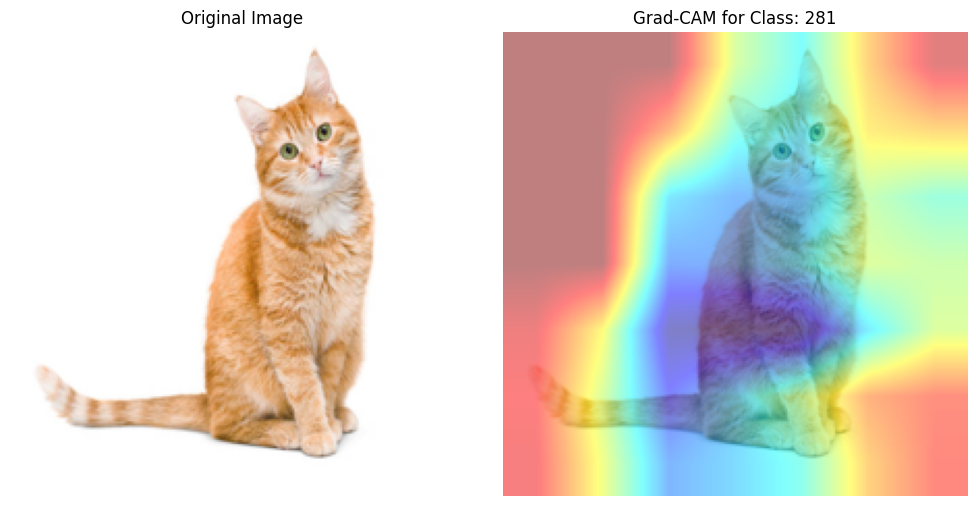

In [8]:
# Visualisation 

# Resize the low-resolution Grad-CAM map (e.g., 7x7) to the original image size (224x224)
heatmap = cv2.resize(grad_cam_map_np, (224, 224))

# Normalise the heatmap to the range [0, 1]
if np.max(heatmap) > 0:
    heatmap = heatmap / np.max(heatmap)

# Convert the normalised heatmap to 8-bit integer (0-255)
heatmap = np.uint8(255 * heatmap)

# Apply the JET colormap 
heatmap_jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Convert the original image to float and normalize it to [0, 1]
original_img_float = original_img_np.astype(np.float32) / 255
# Convert the colored heatmap to float and normalize it to [0, 1]
heatmap_float = heatmap_jet.astype(np.float32) / 255

# Fusion
# Alpha controls the transparency of the heatmap (for example: 0.5 means 50% heatmap, 50% image)
alpha = 0.5 
superimposed_img = (1 - alpha) * original_img_float + alpha * heatmap_float
# Convert the final result back to 8-bit integer (0-255) for display
superimposed_img = np.uint8(255 * superimposed_img) 


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_img_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title(f"Grad-CAM for Class: {predicted_class}")
plt.axis('off')

plt.tight_layout()
plt.show()